In [101]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pyqg
import gcm_filters
import pyqg_subgrid_experiments as pse
%matplotlib inline

# Learning and Evaluating Subgrid Momentum Parameterizations with PYQG

In this notebook, we'll present a framework for learning and evaluating subgrid momentum parameterizations based on ocean simulations run with [pyqg](https://pyqg.readthedocs.io/en/latest/https://pyqg.readthedocs.io/en/latest/).

Among other things, pyqg implements the following two-layer quasi-geostrophic model:

$$
\begin{split}
\partial_t\,{q_1} + \mathsf{J}\left(\psi_1\,, q_1\right) + \beta\, {\psi_1}_x &= \text{ssd} \,,\\
\partial_t\,{q_2} + \mathsf{J}\left(\psi_2\,, q_2\right)+ \beta\, {\psi_2}_x &= -r_{ek}\nabla^2 \psi_2 + \text{ssd}\,,\\
\end{split}
$$

where

$$
\begin{split}
{q_1} &= \nabla^2\psi_1 + F_1\left(\psi_2 - \psi_1\right)\,, \\ 
{q_2} &= \nabla^2\psi_2 + F_2\left(\psi_1 - \psi_2\right)\,, \\
F_1 &= k_d^2 / (1 + (\frac{H_1}{H_2})^2)\,, \\
F_2 &= \frac{H_1}{H_2} \,F_1\,, \\
k_d^2 &= \frac{f_0^2}{g}\frac{H_1+H_2}{H_1 H_2}\,,
\end{split}
$$

and $H_1$, $H_2$ are the depths of each layer. 
Although the model is idealized, we can achieve qualitatively different results by changing $H_1/H_2$, $\beta$, $r_{ek}$, or the size/resolution of the domain.

Let's look at some examples (of quantities obtained from running simulations until quasi-steady state):

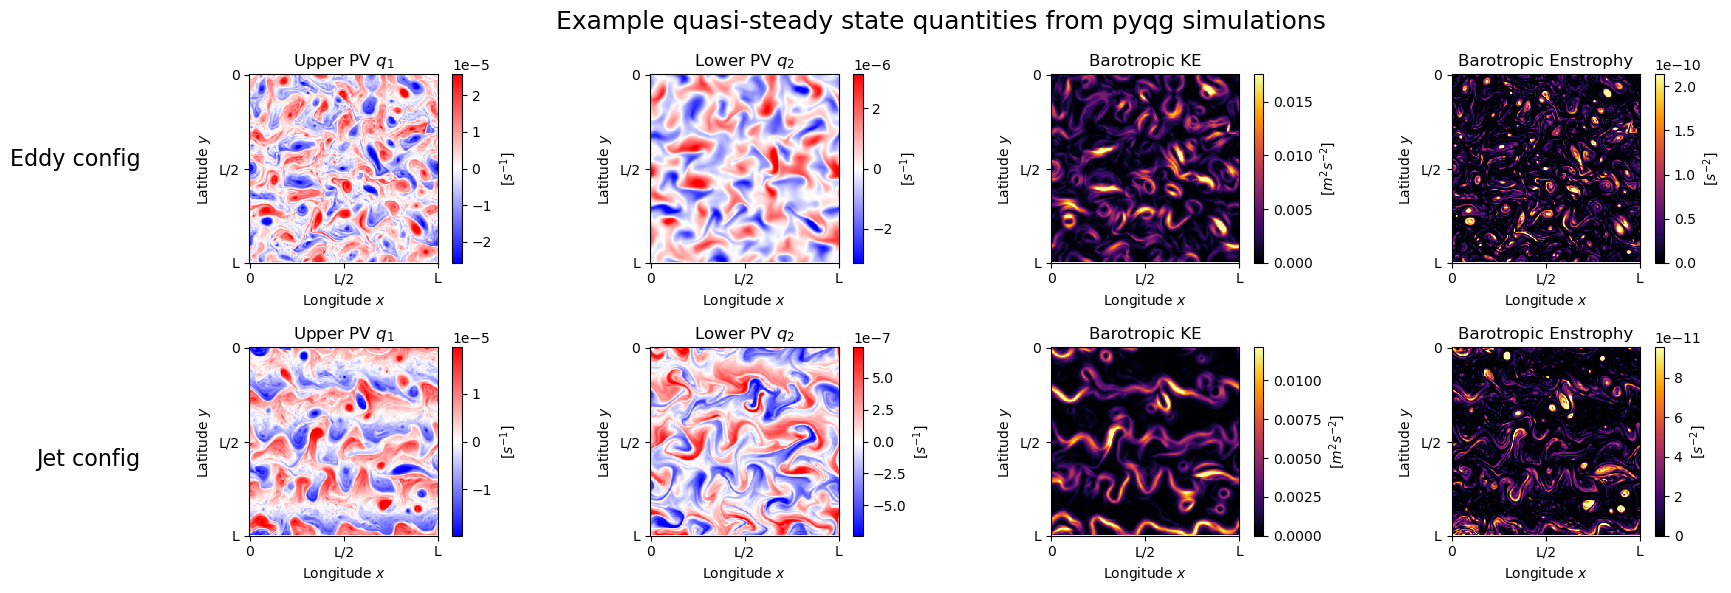

In [3]:
eddy_hires = pse.Dataset("/scratch/zanna/data/pyqg/data/test/hires/*.nc").assign_attrs(label="Hi-res")
jet_hires = pse.Dataset("/scratch/zanna/data/pyqg/data/transfer/hires/*.nc").assign_attrs(label="Hi-res")
with pse.figure_grid(2,4) as g:
    g.title(f"Example quasi-steady state quantities from pyqg simulations", fontsize=18)
    g.fig.text(0, 0.75, 'Eddy config', ha='right', va='top', fontsize=16)
    g.fig.text(0, 0.25, 'Jet config', ha='right', va='top', fontsize=16)
    for ds in [eddy_hires, jet_hires]:
        ds = ds.isel(time=-1, run=-1)
        g.next(title="Upper PV $q_1$"); pse.imshow(ds.q.isel(lev=0), label="[$s^{-1}$]")
        g.next(title="Lower PV $q_2$"); pse.imshow(ds.q.isel(lev=1), label="[$s^{-1}$]")
        g.next(title="Barotropic KE");  pse.imshow(ds.ke.sum(dim='lev'), label="[$m^2 s^{-2}$]")
        g.next(title="Barotropic Enstrophy"); pse.imshow(ds.enstrophy.sum(dim='lev'), label="[$s^{-2}$]")

We can see that in the "eddy" configuration, eddies are randomly distributed across many latitudes, while in the "jet" configuration, they form coherent jets.

We can also run simulations at lower resolutions:

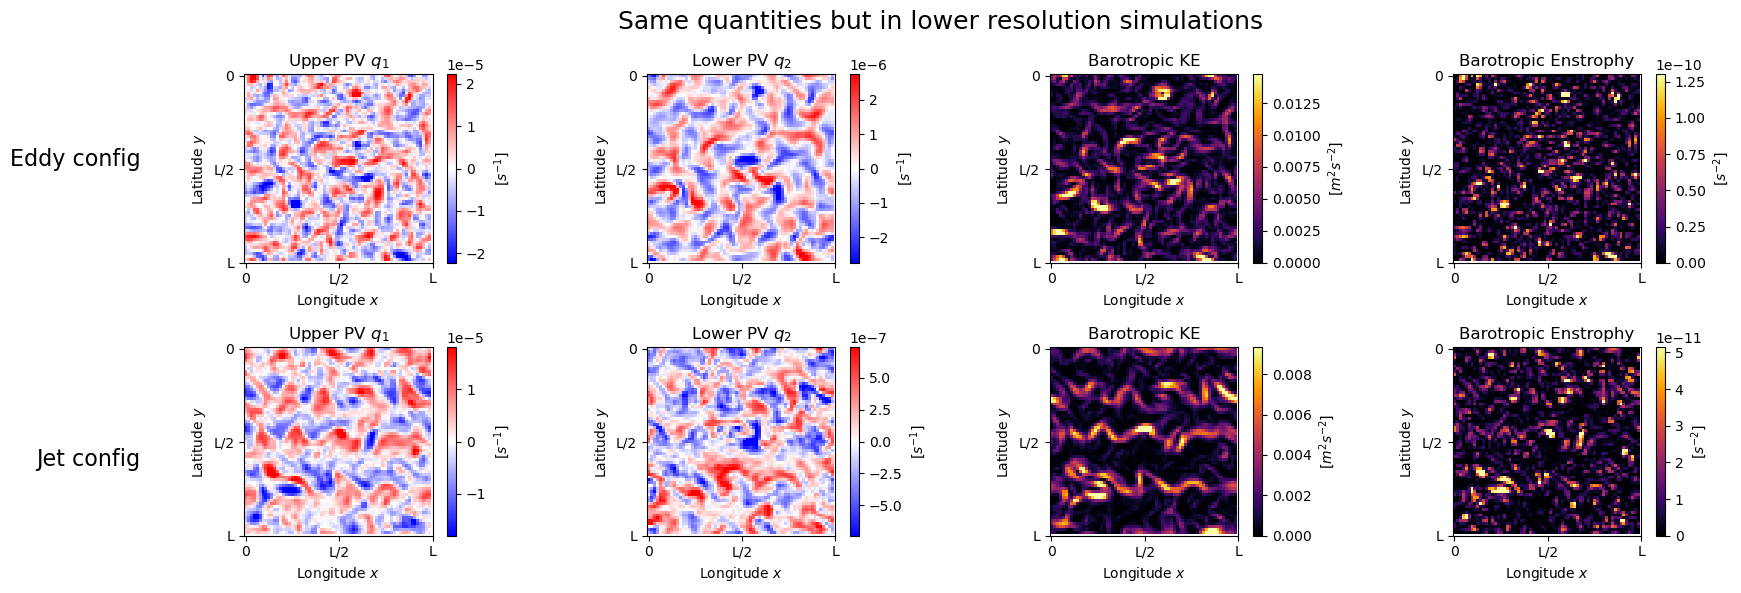

In [4]:
eddy_lores = pse.Dataset("/scratch/zanna/data/pyqg/data/test/lores/*.nc").assign_attrs(label="Lo-res")
jet_lores = pse.Dataset("/scratch/zanna/data/pyqg/data/transfer/lores/*.nc").assign_attrs(label="Lo-res")
with pse.figure_grid(2,4) as g:
    g.title(f"Same quantities but in lower resolution simulations", fontsize=18)
    g.fig.text(0, 0.75, 'Eddy config', ha='right', va='top', fontsize=16)
    g.fig.text(0, 0.25, 'Jet config', ha='right', va='top', fontsize=16)
    for ds in [eddy_lores, jet_lores]:
        ds = ds.isel(time=-1, run=-1)
        g.next(title="Upper PV $q_1$"); pse.imshow(ds.q.isel(lev=0), label="[$s^{-1}$]")
        g.next(title="Lower PV $q_2$"); pse.imshow(ds.q.isel(lev=1), label="[$s^{-1}$]")
        g.next(title="Barotropic KE");  pse.imshow(ds.ke.sum(dim='lev'), label="[$m^2 s^{-2}$]")
        g.next(title="Barotropic Enstrophy"); pse.imshow(ds.enstrophy.sum(dim='lev'), label="[$s^{-2}$]")

In this particular case, the lower-resolution simulations still do a reasonable job capturing similar flow characteristics, though how they still differ in how they distribute energy and other quantities across spatial scales:

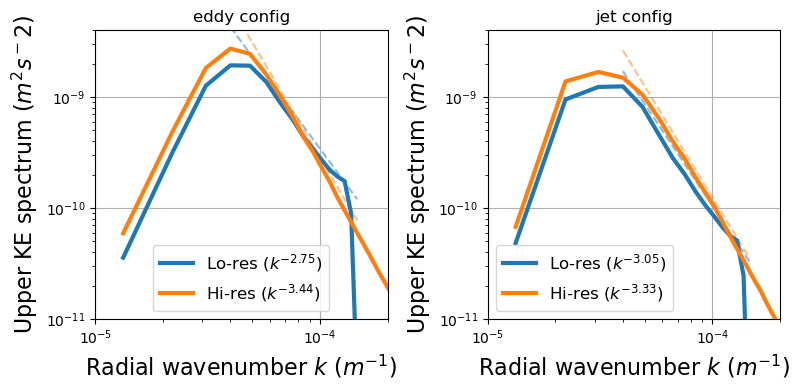

In [5]:
with pse.figure_grid(1,2,rowheight=4) as g:
    for c in ['eddy','jet']:
        g.next(title=f"{c} config")
        pse.plot_spectra('KEspec', [eval(f"{c}_{r}res") for r in ['lo','hi']], z=0)
        plt.xlim(1e-5,2e-4); plt.ylim(1e-11,4e-9)
        plt.ylabel("Upper KE spectrum ($m^2 s^-2$)")

## Subgrid forcing and parameterizations

We'd like to be able to run simulations at low resolution, but have the results look as if we had run a simulation at high resolution, but then scaled it down.

To do this, we'd like to add a correction term, or _parameterization_, to $\delta_t q$ at each timestep which accounts for the unresolved physics and numerical error (called _subgrid forcing_). This subgrid forcing parameterization must only be a function of the low-resolution variables.

We can obtain parameterizations from applying physical knowledge, we can try to learn them from data, or we can do some combination of both. We can also use many different possible inputs for parameterizations, or apply their outputs in many different ways. **Which is best?**

In this talk, we'll focus on issues around _evaluation_ of subgrid forcing parameterizations.

### Offline vs. online metrics

- **Offline metrics** test how well a parameterization predicts subgrid forcing. They can be computed without needing to run any simulations. Examples include:
    - Correlation
    - $R^2$
    - Mean squared error
- **Online metrics** test how well a parameterization improves the physical realism of a low-resolution simulation. They can only be computed by running simulations. Examples include:
    - Similarity of probability distributions between high-res and (un)parameterized low-res
    - Similarity of spatial spectra between high-res and (un)parameterized low-res

### Filtering and Coarse-Graining High-Resolution Data

There are many ways of filtering and coarse-graining data (we pick the version from [Guan 2021](https://arxiv.org/abs/2102.11400), based on Turbulent Flows by Pope):

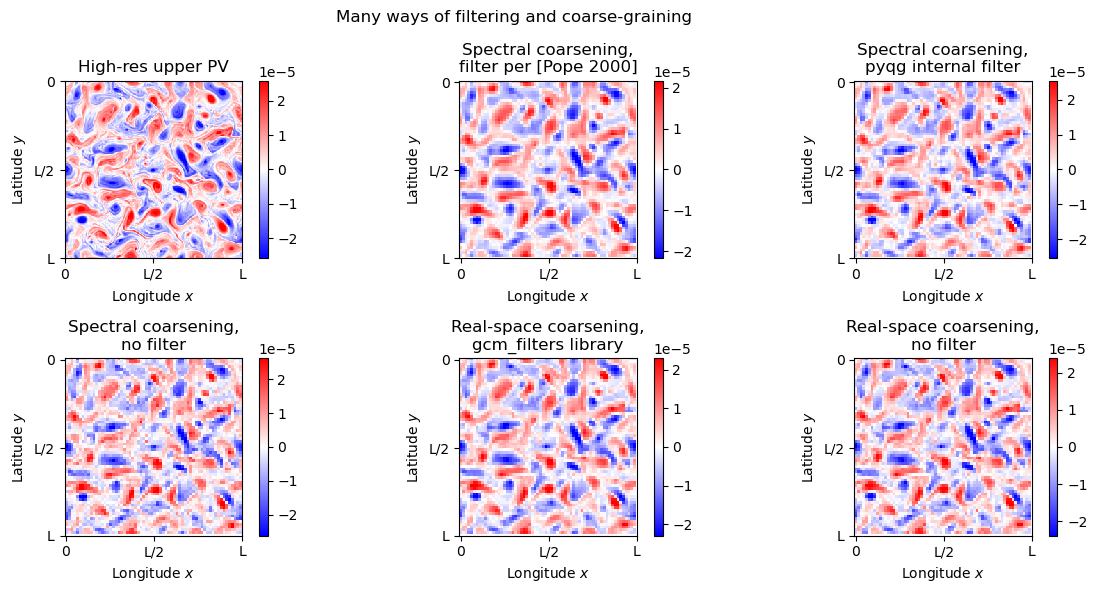

In [6]:
q_hires_var = eddy_hires.q.isel(run=-1, time=-1)
q_hires = np.array(q_hires_var.data).astype(np.float64)
spec_filt = lambda f=None: pse.spectral_filter_and_coarsen(q_hires, eddy_hires, eddy_lores, filtr=f)[0]
real_filt = gcm_filters.Filter(filter_scale=4, dx_min=1)
with pse.figure_grid(2,3) as g:
    g.title("Many ways of filtering and coarse-graining")
    g.next(); pse.imshow(q_hires[0],                    title="High-res upper PV")
    g.next(); pse.imshow(spec_filt(),                   title="Spectral coarsening,\nfilter per [Pope 2000]")
    g.next(); pse.imshow(spec_filt(eddy_lores.m.filtr), title="Spectral coarsening,\npyqg internal filter")
    g.next(); pse.imshow(spec_filt(1.0),                title="Spectral coarsening,\nno filter")
    g.next(); pse.imshow(real_filt.apply(q_hires_var, dims=['y','x']).coarsen(x=4, y=4).mean()[0], title="Real-space coarsening,\ngcm_filters library" )
    g.next(); pse.imshow(q_hires_var.coarsen(x=4, y=4).mean()[0], title="Real-space coarsening,\nno filter")

### Diagnosing Subgrid Forcing

Even beyond the choice of filter, there are multiple ways of diagnosing subgrid forcing (which we make available in the dataset). Here are several for the potential vorticity:

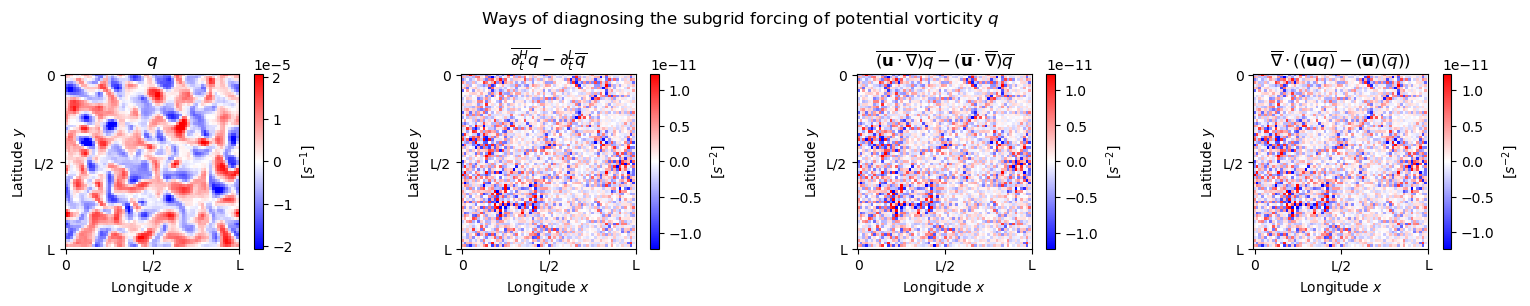

In [7]:
ds = pse.Dataset("/scratch/zanna/data/pyqg/data/train/0.nc").isel(time=-1, run=-1, lev=0).load()
with pse.figure_grid(1,4) as g:
    g.title("Ways of diagnosing the subgrid forcing of potential vorticity $q$")
    g.next(); pse.imshow(ds.q,                      label="[$s^{-1}$]", title="$q$")
    g.next(); pse.imshow(ds.q_forcing_total,        label="[$s^{-2}$]", title=r"$\overline{\partial_t^H q} - \partial_t^L \overline{q}$")
    g.next(); pse.imshow(ds.q_forcing_advection,    label="[$s^{-2}$]", title=r"$\overline{(\mathbf{u} \cdot \nabla)q} - (\overline{\mathbf{u}} \cdot \overline{\nabla})\overline{q}$")
    g.next(); pse.imshow(ds.ddx('uq_subgrid_flux') 
                       + ds.ddy('vq_subgrid_flux'), label="[$s^{-2}$]", title=r"$\overline{\nabla} \cdot (\overline{(\mathbf{u} q)} - (\overline{\mathbf{u}})(\overline{q}))$")

And for the velocity:

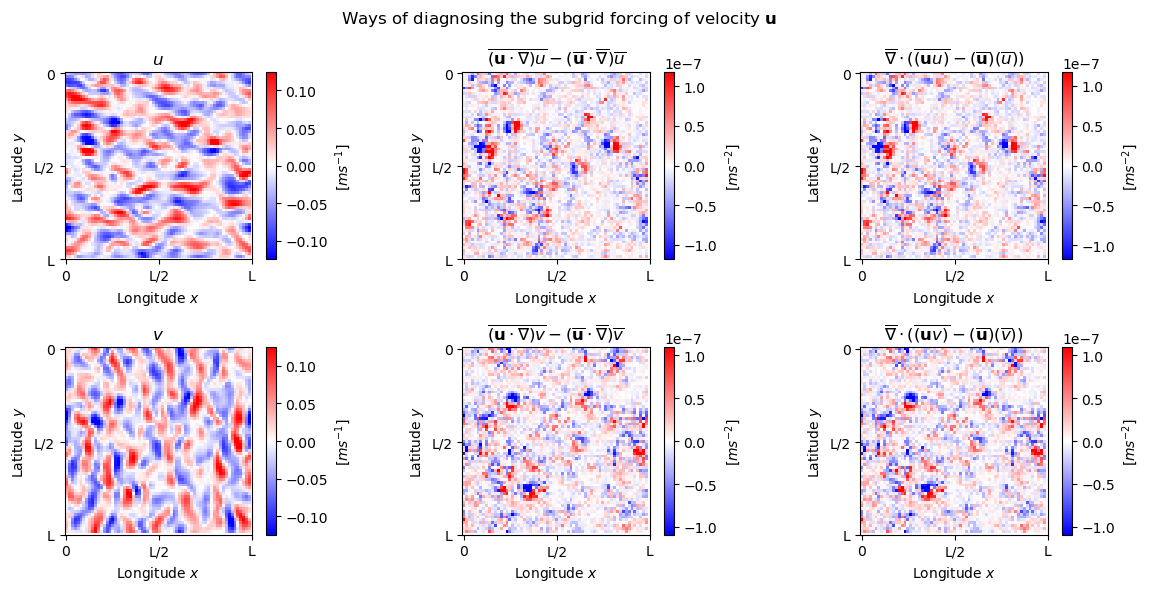

In [8]:
with pse.figure_grid(2,3) as g:
    g.title("Ways of diagnosing the subgrid forcing of velocity $\mathbf{u}$")
    g.next(); pse.imshow(ds.u,                      label="[$ms^{-1}$]", title="$u$")
    g.next(); pse.imshow(ds.u_forcing_advection,    label="[$ms^{-2}$]", title=r"$\overline{(\mathbf{u} \cdot \nabla)u} - (\overline{\mathbf{u}} \cdot \overline{\nabla})\overline{u}$")
    g.next(); pse.imshow(ds.ddx('uu_subgrid_flux')
                       + ds.ddy('uv_subgrid_flux'), label="[$ms^{-2}$]", title=r"$\overline{\nabla} \cdot (\overline{(\mathbf{u} u)} - (\overline{\mathbf{u}})(\overline{u}))$")
    g.next(); pse.imshow(ds.v,                      label="[$ms^{-1}$]", title="$v$")
    g.next(); pse.imshow(ds.v_forcing_advection,    label="[$ms^{-2}$]", title=r"$\overline{(\mathbf{u} \cdot \nabla)v} - (\overline{\mathbf{u}} \cdot \overline{\nabla})\overline{v}$")
    g.next(); pse.imshow(ds.ddx('uv_subgrid_flux')
                       + ds.ddy('vv_subgrid_flux'), label="[$ms^{-2}$]", title=r"$\overline{\nabla} \cdot (\overline{(\mathbf{u} v)} - (\overline{\mathbf{u}})(\overline{v}))$")

## Example Parameterizations

To illustrate our metrics, let's introduce two parameterizations. The first is the physical parameterization learned by equation discovery in [Zanna and Bolton 2020](https://laurezanna.github.io/files/Zanna-Bolton-2020.pdf), which uses local vorticity, shearing, and stretching terms to predict subgrid forcing in terms of velocity tendencies (which are converted to PV tendencies via taking a curl):

In [14]:
class ZB2020Parameterization(pse.Parameterization):
    def __init__(self, factor):
        self.factor = factor

    @property
    def targets(self): return ['u_forcing_advection', 'v_forcing_advection']

    def predict(self, m):
        # Eq. 6 of https://laurezanna.github.io/files/Zanna-Bolton-2020.pdf
        ds = pse.Dataset.wrap(m)
        
        vort    = ds.ddx('v') - ds.ddy('u')
        shear   = ds.ddx('v') + ds.ddy('u')
        stretch = ds.ddx('u') - ds.ddy('v')
        sum_sqs = (vort**2 + shear**2 + stretch**2) / 2.0
        
        Su = self.factor * (ds.ddx(sum_sqs-vort*shear) + ds.ddy(vort*stretch))
        Sv = self.factor * (ds.ddy(sum_sqs+vort*shear) + ds.ddx(vort*stretch))

        return dict(u_forcing_advection=Su, v_forcing_advection=Sv)

We can instantiate and evaluate this parameterization as follows:

In [25]:
param = ZB2020Parameterization(factor=-46761284) # chosen by tuning to train set
eddy_dataset = pse.Dataset("/scratch/zanna/data/pyqg/data/test/*.nc").assign_attrs(label="Hi-res, downscaled")
jet_dataset = pse.Dataset("/scratch/zanna/data/pyqg/data/transfer/*.nc").assign_attrs(label="Hi-res, downscaled")
eddy_preds = param.test_offline(eddy_dataset).assign_attrs(label="ZB2020").load()
jet_preds = param.test_offline(jet_dataset).assign_attrs(label="ZB2020").load()

Offline, we've also trained a fully convolutional neural network (based on training data from the eddy configuration), and made predictions for the same test sets:

In [26]:
# Trained and run offline, since it takes GPUs!
fcnn_path = "/scratch/zanna/data/pyqg/models/fcnn_u-v_u_forcing_advection-v_forcing_advection_zeromean1_layerwise01/0"
eddy_preds_nn = xr.open_dataset(f"{fcnn_path}/test/offline_metrics.nc").assign_attrs(label="FCNN")
jet_preds_nn = xr.open_dataset(f"{fcnn_path}/transfer/offline_metrics.nc").assign_attrs(label="FCNN")

Architecturally, it looks like this:

In [22]:
pse.models.FullyCNN(['u','v'], ['u_forcing_advection', 'v_forcing_advection'])

FullyCNN(
  (0): Conv2d(2, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU()
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU()
  (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU()
  (14): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (15): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (16): ReLU()
  (17): BatchNorm2d(32, 

In [78]:
def plot_score_over_time(key, *preds):
    for p in preds:
        time = p.time / np.timedelta64(1, 'D')
        y = p[f"u_forcing_advection_temporal_{key}"]
        up = plt.plot(time, y.isel(lev=0), label=f"{p.attrs['label']}, upper")[0]
        lo = plt.plot(time, y.isel(lev=1), label=f"{p.attrs['label']}, lower", ls='--', color=up._color)
    plt.ylabel(key)
    plt.xlabel("Model time (days)")
    plt.legend(loc='best')
    plt.grid(alpha=0.25)
    if key == 'skill':
        plt.yticks(range(-6,2))
        plt.ylim(-6,1.5)
        plt.ylabel("$R^2$ predicting $S_u$")
        plt.axhline(0, color='gray', ls=':')
    
def plot_score_over_space(preds, key, z, **kw):
    pse.imshow(preds[f"u_forcing_advection_spatial_{key}"].isel(lev=z),
                title=f"{['upper','lower'][z]}", **kw)

Now let's compare offline performance, in this case in terms of $R^2$ at predicting the subgrid forcing of zonal momentum, as a function of the model timestep:

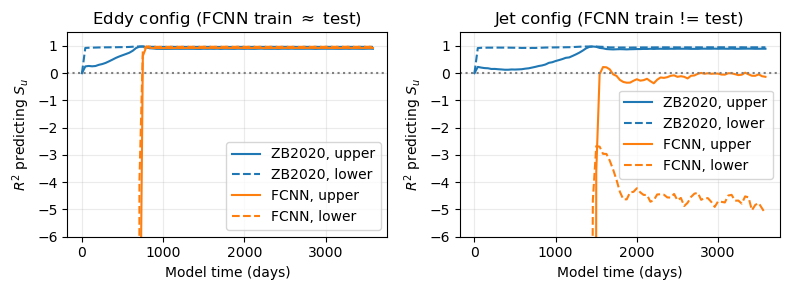

In [79]:
with pse.figure_grid(1,2) as g:
    g.next(title=r"Eddy config (FCNN train $\approx$ test)")
    plot_score_over_time('skill', eddy_preds, eddy_preds_nn)
    g.next(title=r"Jet config (FCNN train != test)")
    plot_score_over_time('skill', jet_preds, jet_preds_nn)

Both parameterizations achieve $R^2$ near 1 in the eddy configuration, but only after the model reaches quasi-steady state. The FCNN does much worse in jet configuration (where it saw no training data).

Digging into the specific numbers:

In [68]:
skill_over = lambda t, d: round(float(d.u_forcing_advection_temporal_skill.isel(time=t).mean()),2)
transient_r2 = lambda d: skill_over(slice(None, 10), d)
quasi_steady_r2 = lambda d: skill_over(slice(-10, None), d)
for c in ['eddy','jet']:
    print(c + ' config')
    for t in ['quasi_steady','transient']:
        print('  ', t)
        print(f"     FCNN: R^2 =", eval(f"{t}_r2({c}_preds_nn)"))
        print(f"     ZB20: R^2 =", eval(f"{t}_r2({c}_preds)"))

eddy config
   quasi_steady
     FCNN: R^2 = 0.95
     ZB20: R^2 = 0.93
   transient
     FCNN: R^2 = -340261.84
     ZB20: R^2 = 0.57
jet config
   quasi_steady
     FCNN: R^2 = -2.43
     ZB20: R^2 = 0.92
   transient
     FCNN: R^2 = -24195054.0
     ZB20: R^2 = 0.5


The FCNN does actually get higher $R^2$ than the physical parameterization in the quasi-steady state of the eddy configuration. However, it gets much lower scores in other contexts.

We can also look at other metrics, such as correlation:

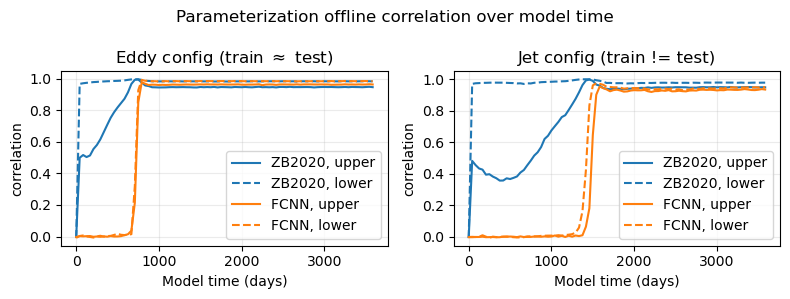

In [36]:
with pse.figure_grid(1,2) as g:
    g.title("Parameterization offline correlation over model time")
    g.next(title=r"Eddy config (train $\approx$ test)")
    plot_score_over_time('correlation', eddy_preds, eddy_preds_nn)
    g.next(title=r"Jet config (train != test)")
    plot_score_over_time('correlation', jet_preds, jet_preds_nn)

Or plot metrics over space:

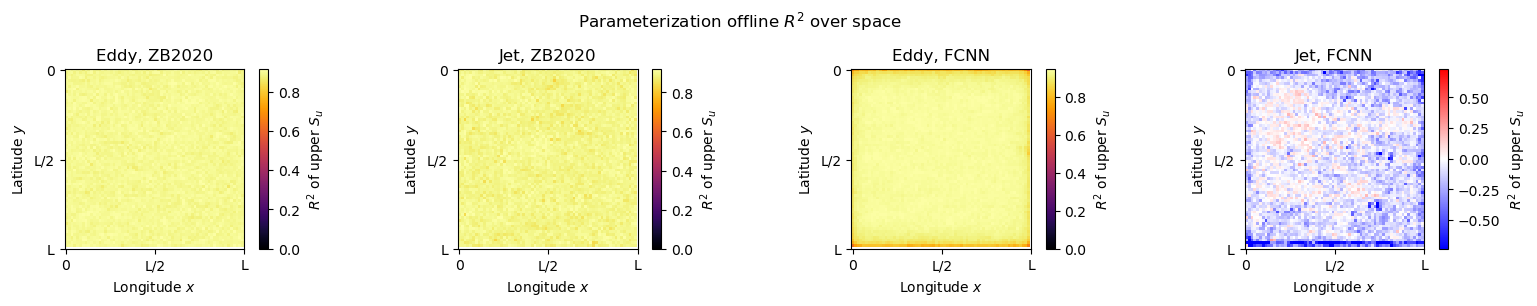

In [81]:
with pse.figure_grid(1,4) as g:
    g.title("Parameterization offline $R^2$ over space")
    g.next(title=r"Eddy, ZB2020"); plot_score_over_space(eddy_preds, 'skill', z=0, label="$R^2$ of upper $S_u$")
    g.next(title=r"Jet, ZB2020"); plot_score_over_space(jet_preds, 'skill', z=0, label="$R^2$ of upper $S_u$")
    g.next(title=r"Eddy, FCNN"); plot_score_over_space(eddy_preds_nn, 'skill', z=0, label="$R^2$ of upper $S_u$")
    g.next(title=r"Jet, FCNN"); plot_score_over_space(jet_preds_nn, 'skill', z=0, label="$R^2$ of upper $S_u$")

The physical parameterization has roughly uniform predictions over space, while the FCNN shows slight degradations around the edges (it's not handling periodic boundaries) and uneven performance on the jet configuration.

### Online Metrics

Start by defining distance metrics between spectra ($D_{spectra}(\cdot || \cdot)$) and probability distributions ($D_{distrib}(\cdot || \cdot)$).

For example, we might choose:
- $D_{distrib}(\cdot || \cdot)$ = Earth mover's distance
- $D_{spectra}(\cdot || \cdot)$ = Magnitude of difference between best-fit log-log slopes over given set of lengthscales
- $D_{spectra}(\cdot || \cdot)$ = Mean squared error between curves over given set of lengthscales

Then for any parameterization, define a similiarity score to a high-resolution target as:

- $S(\mathtt{param}) = 1 - \frac{D(\mathtt{hires\_target} || \mathtt{lores\_with\_param})}{D(\mathtt{hires\_target} || \mathtt{lores\_without\_param})}$

This score approaches 1 when the parameterization brings the resulting spectrum or distribution much closer to the high resolution target than the unparameterized model.

### Picking the right target

One question we've been debating is whether it's better for the low-res parameterized model to match the high-res model directly, or a _downscaled_ version of it.

This is actually a complicated question that depends on the specific metric in question; for now, we'll show both.

Here's how we can run parameterizations online:

In [104]:
if False:
    eddy_zb2020 = xr.concat([param.run_online(**test_dataset.pyqg_params) for _ in range(5)], 'run')
    jet_zb2020 = xr.concat([param.run_online(**xfer_dataset.pyqg_params) for _ in range(5)], 'run')

Since that takes a while to run in practice, we'll load up some existing simulations instead:

In [82]:
zb2020_path = "/scratch/zanna/data/pyqg/models/zb2020_1.0"
jet_zb2020 = pse.Dataset(f"{zb2020_path}/transfer/online_simulations/*.nc")
eddy_zb2020 = pse.Dataset(f"{zb2020_path}/test/online_simulations/*.nc")
eddy_zb2020 = eddy_zb2020.assign_attrs(label="Lo-res + ZB2020 param", plot_kwargs=dict(ls='--'))
jet_zb2020 = jet_zb2020.assign_attrs(label="Lo-res + ZB2020 param", plot_kwargs=dict(ls='--'))

eddy_fcnn = pse.Dataset(f"{fcnn_path}/test/online_simulations/*.nc")
eddy_fcnn = eddy_fcnn.assign_attrs(label="Lo-res + FCNN param", plot_kwargs=dict(ls='--'))
jet_fcnn = pse.Dataset(f"{fcnn_path}/transfer/online_simulations/*.nc")
jet_fcnn = jet_fcnn.assign_attrs(label="Lo-res + FCNN param", plot_kwargs=dict(ls='--'))

eddy_conditions = [eddy_lores, eddy_hires, test_dataset, eddy_zb2020, eddy_fcnn]
jet_conditions = [jet_lores, jet_hires, xfer_dataset, jet_zb2020, jet_fcnn]

Let's explore our online metric evaluation using the spectrum of upper-level kinetic energy:

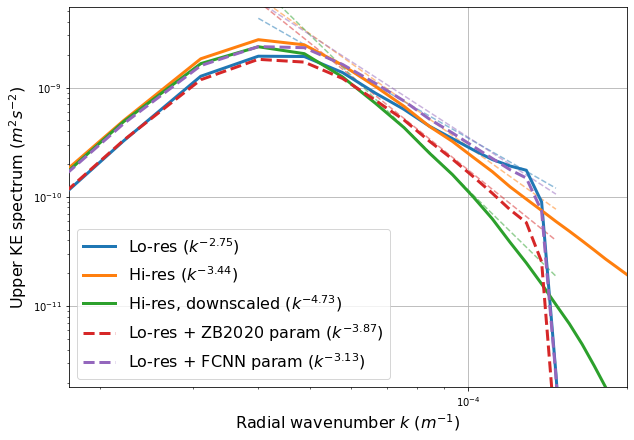

In [119]:
plt.figure(figsize=(10,7))
pse.plot_spectra('KEspec', eddy_conditions, z=0)
plt.xlim(1.75e-5, 2e-4); plt.show()

The FCNN matches best at large lengthscales. The physical parameterization, on the other hand, is potentially better at small lengthscales -- though it depends whether "Hi-res" or "Hi-res, downscaled" is the target.

In [97]:
def curve_sim(spec, param, hires, lores, kmin, kmax, z=None):
    k1, pspec = param.isotropic_spectrum(spec, z=z)
    k2, hspec = hires.isotropic_spectrum(spec, z=z)
    k3, lspec = lores.isotropic_spectrum(spec, z=z)
    i = np.argmin(np.abs(np.log(k1) - np.log(kmin)))
    j = np.argmin(np.abs(np.log(k1) - np.log(kmax)))
    d1 = ((pspec[i:j] - hspec[i:j])**2).sum()
    d2 = ((lspec[i:j] - hspec[i:j])**2).sum()
    return 1 - d1/d2

def slope_sim(spec, param, hires, lores, z=None):
    pslope = param.spectral_linregress(spec, z=z).slope
    hslope = hires.spectral_linregress(spec, z=z).slope
    lslope = lores.spectral_linregress(spec, z=z).slope
    d1 = abs(pslope - hslope)
    d2 = abs(lslope - hslope)
    return 1 - d1/d2

Let's try to quantify this by computing our slope similarity metric ($S(\mathtt{param}) = 1 - \frac{|\mathrm{slope}_{\mathrm{hires}}-\mathrm{slope}_{\mathrm{param}}|}{|\mathrm{slope}_{\mathrm{hires}}-\mathrm{slope}_{\mathrm{lores}}|}$):

In [99]:
for target_name, target_sims in [('high-res', eddy_hires), ('downscaled high-res', test_dataset)]:
    print(f"for target = {target_name}")
    for param_name, param_sims in [('ZB20', eddy_zb2020), ('FCNN', eddy_fcnn)]:
        sim = slope_sim('KEspec', param_sims, target_sims, eddy_lores, z=0)
        print(f"  {param_name} slope similarity = {sim:.2f}")

for target = high-res
  ZB20 slope similarity = 0.37
  FCNN slope similarity = 0.54
for target = downscaled high-res
  ZB20 slope similarity = 0.56
  FCNN slope similarity = 0.19


As we noted before, which parameterization matches best depends on the target. In all cases, though, the parameterized models have better-matching slopes than low-resolution models.

We can also compute raw curve similarity, at both large and small lengthscales:

In [94]:
for target_name, target_sims in [('high-res', eddy_hires), ('downscaled high-res', test_dataset)]:
    print(f"for target = {target_name}")
    for length_name, kmin, kmax in [("larger", 1e-5, 2e-5), ("smaller", 5e-5, 1e-4)]:
        print(f"  at {length_name} lengthscales")
        for param_name, param_sims in [('ZB20', eddy_zb2020), ('FCNN', eddy_fcnn)]:
            sim = curve_sim('KEspec', param_sims, target_sims, eddy_lores, kmin=kmin, kmax=kmax, z=0)
            print(f"    {param_name} curve similarity = {sim:.2f}")

for target = high-res
  at larger lengthscales
    ZB20 curve similarity = 0.10
    FCNN curve similarity = 0.95
  at smaller lengthscales
    ZB20 curve similarity = -1.31
    FCNN curve similarity = 0.89
for target = downscaled high-res
  at larger lengthscales
    ZB20 curve similarity = 0.13
    FCNN curve similarity = 1.00
  at smaller lengthscales
    ZB20 curve similarity = 0.23
    FCNN curve similarity = -2.45


Here, the FCNN ends up looking much better in most contexts, though if we take the downscaled high-resolution model as our target, the physical parameterization does better at small lengthscales.

In addition to spectra, we can also compare marginal distributions of different quantities. Let's consider the enstrophy:

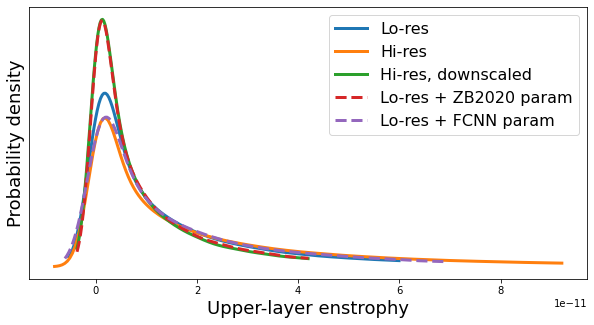

In [120]:
plt.figure(figsize=(10,5))
for ds in eddy_conditions:
    data = ds.enstrophy.isel(lev=0, time=slice(-5,None), run=slice(-5,None)).data
    pse.kdeplot(data, label=ds.label, lw=3, **ds.attrs.get('plot_kwargs', {}))
plt.legend(loc='best', fontsize=16)
plt.xlabel("Upper-layer enstrophy", fontsize=18); plt.ylabel("Probability density", fontsize=18); plt.show()

As before, the physical parameterization is closer to the downscaled high-res model, while the FCNN is closer to the original high-res model.

In [112]:
def dist_sim(q, param, hires, lores, z=None):
    from scipy.stats import wasserstein_distance
    dists = [np.array(ds[q].isel(lev=z, time=slice(-5,None), run=slice(-5,None)).data).ravel()
             for ds in [param,hires,lores]]
    W1 = wasserstein_distance(dists[0], dists[1])
    W2 = wasserstein_distance(dists[2], dists[1])
    return 1 - W1/W2

Our quantitative metrics reflect this too:

In [113]:
for target_name, target_sims in [('high-res', eddy_hires), ('downscaled high-res', test_dataset)]:
    print(f"for target = {target_name}")
    for param_name, param_sims in [('ZB20', eddy_zb2020), ('FCNN', eddy_fcnn)]:
        sim = dist_sim('enstrophy', param_sims, target_sims, eddy_lores, z=0)
        print(f"  {param_name} enstrophy similarity = {sim:.2f}")

for target = high-res
  ZB20 enstrophy similarity = -0.54
  FCNN enstrophy similarity = 0.29
for target = downscaled high-res
  ZB20 enstrophy similarity = 0.91
  FCNN enstrophy similarity = -0.53


### Summary

- we introduced a number of ways of evaluating parameterizations both online and offline
- some of the online metrics require choosing a target (e.g. high-res or downscaled high-res), that can be tricky
- we are using these metrics to compare a wide variety of models, trained with a variety of inputs to predict a variety of subgrid forcing formulations (not covered in this talk)
- more details at [`examples/testbed_demo.ipynb`](https://github.com/m2lines/pyqg_experiments/blob/master/examples/testbed_demo.ipynb) at <https://github.com/m2lines/pyqg_experiments>!

### For Discussion

- are there additional metrics you think we should include?
- what are your thoughts on best practices for evaluating parameterizations? what general principles hold across models / settings?